In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, anderson
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
plt.rcParams["figure.dpi"] = 150

In [ ]:
a1, b1 = 3, 50
a2, b2 = 3, 40
lower = min(beta.ppf(0.001, a1, b1), beta.ppf(0.001, a2, b2))
upper = max(beta.ppf(0.999, a1, b1), beta.ppf(0.999, a2, b2))
x = np.linspace(lower, upper, 200)

In [ ]:
plt.plot(x, beta.pdf(x, a1, b1));
plt.plot(x, beta.pdf(x, a2, b2));

In [ ]:
control_cog = np.round(beta.rvs(a1, b1, size = 70, scale = 40), 1)
treat_cog = np.round(beta.rvs(a2, b2, size = 50, scale = 40), 1)

In [ ]:
plt.hist(control_cog, alpha = 0.5, bins = np.arange(0, 7, 0.25), edgecolor="white");
plt.hist(treat_cog, alpha = 0.5, bins = np.arange(0, 7, 0.25), edgecolor="white");

In [ ]:
np.mean(control_cog), np.mean(treat_cog)

# Population

In [2]:
anime = pd.read_csv("anime.csv")
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24012 entries, 0 to 24011
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           24012 non-null  int64  
 1   title                        24012 non-null  object 
 2   media_type                   24012 non-null  object 
 3   mean                         14153 non-null  float64
 4   num_scoring_users            24012 non-null  int64  
 5   status                       24012 non-null  object 
 6   num_episodes                 24012 non-null  int64  
 7   start_date                   21160 non-null  object 
 8   end_date                     19719 non-null  object 
 9   source                       20238 non-null  object 
 10  num_list_users               24012 non-null  int64  
 11  popularity                   20538 non-null  float64
 12  num_favorites                24012 non-null  int64  
 13  rank            

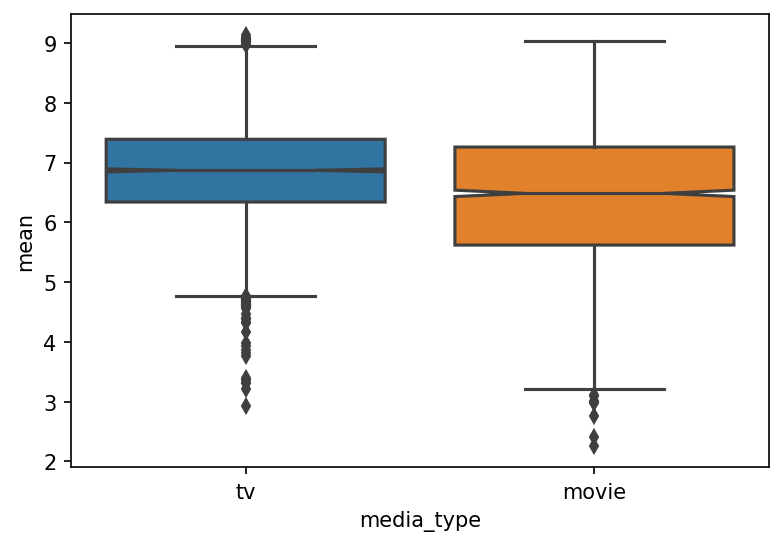

In [87]:
anime_tv_movie = anime.loc[anime.media_type.isin(["tv", "movie"]), :]
ax = sns.boxplot(x="media_type", y="mean", data=anime_tv_movie, notch=True)

In [88]:
counts = anime_tv_movie.media_type.value_counts()
counts

tv       8047
movie    4086
Name: media_type, dtype: int64

In [89]:
tv_movie_diff_mean = np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "tv", "mean"]) \
    - np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "movie", "mean"])

Population parameter

In [90]:
tv_movie_diff_mean

0.43272950295727686

In [93]:
tv_movie_stdevs = anime_tv_movie.groupby("media_type")["mean"].apply(np.std)
tv_movie_stdevs

media_type
movie    1.063442
tv       0.795004
Name: mean, dtype: float64

# Sampling distribution
## Samples of size 200

In [97]:
def create_sampling_dist(population, score_column, group_column, group_labels, group_sizes, num_resamples):
    sampling_dist_diffs = []
    sample_size = group_sizes[0] + group_sizes[1]
    first_population_group = population.loc[population[group_column] == group_labels[0], score_column]
    second_population_group = population.loc[population[group_column] == group_labels[1], score_column]
    for i in range(num_resamples):
        first_group_sample = first_population_group.sample(group_sizes[0], replace=False)
        second_group_sample = second_population_group.sample(group_sizes[1], replace=False)
        first_group_sample_mean = first_group_sample.mean()
        second_group_sample_mean = second_group_sample.mean()
        this_diff = first_group_sample_mean - second_group_sample_mean
        sampling_dist_diffs.append([i + 1, f"{}", first_group_sample_mean, second_group_sample_mean, this_diff])
    return pd.DataFrame(sampling_dist_diffs, \
        columns=["resample", "sample_size", "first_group_mean", "second_group_mean", \
                 f'diff_mean_{score_column}_{group_labels[0]}_{group_labels[1]}'])

In [98]:
sampling_dist_diffs = create_sampling_dist(anime_tv_movie, "mean", "media_type", ["tv", "movie"], [200, 200], 20000)

In [99]:
sampling_dist_diffs

,resample,sample_size,first_mean,second_mean,diff_mean_mean_tv_movie
0,1,400,6.963333,6.721212,0.242121
1,2,400,6.850965,6.284911,0.566054
2,3,400,6.935000,6.244286,0.690714
3,4,400,6.899515,6.396636,0.502879
4,5,400,6.957500,6.370377,0.587123
...,...,...,...,...,...
19995,19996,400,6.819709,6.419391,0.400317
19996,19997,400,6.793208,6.310973,0.482234
19997,19998,400,6.852178,6.530261,0.321917
19998,19999,400,6.857905,6.462895,0.395010


Let's have a look at a single sample

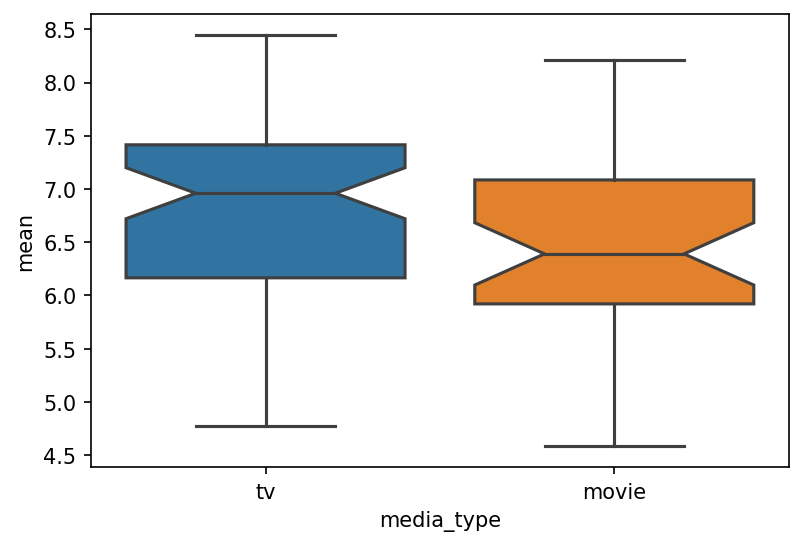

In [43]:
single_sample = anime_tv_movie.sample(200, replace=False)
ax = sns.boxplot(x="media_type", y="mean", data=single_sample, notch=True)

In [32]:
single_sample.media_type.value_counts()

tv       127
movie     73
Name: media_type, dtype: int64

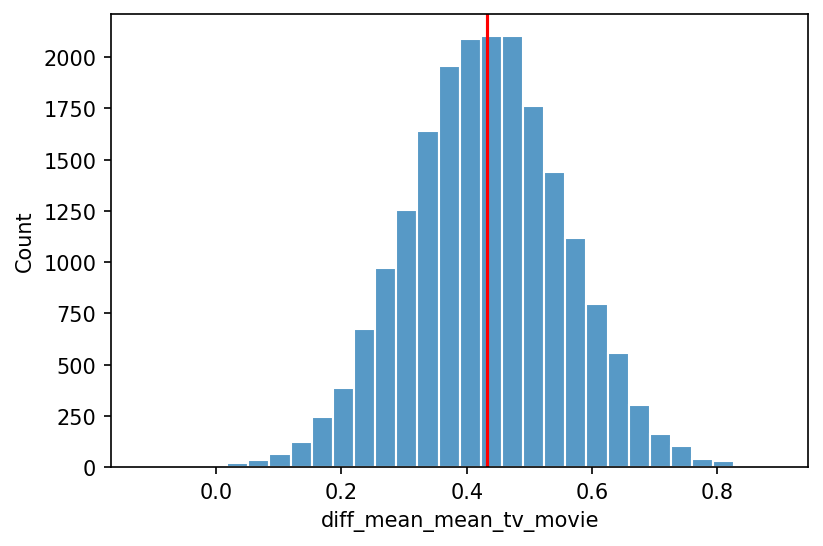

In [83]:
ax = sns.histplot(sampling_dist_diffs.diff_mean_mean_tv_movie, bins=30, edgecolor="white");
plt.axvline(tv_movie_diff, 0, 1, color="red");

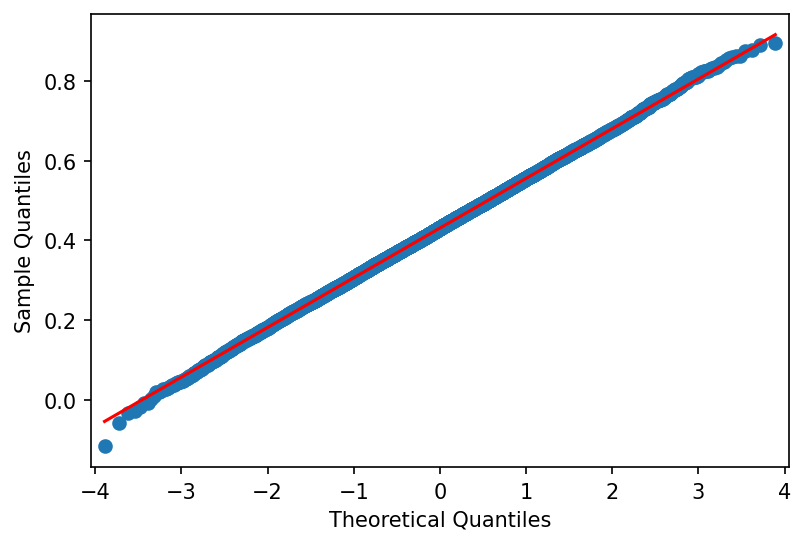

In [84]:
sm.qqplot(sampling_dist_diffs.diff_mean_mean_tv_movie, line="s");

In [94]:
np.std(sampling_dist_diffs.diff_mean_mean_tv_movie)

0.12480810441365792

In [104]:
np.std(sampling_dist_diffs.first_mean), tv_movie_stdevs["tv"]/200**0.5

(0.07776742507034118, 0.056215243621060985)

In [105]:
np.std(sampling_dist_diffs.second_mean), tv_movie_stdevs["movie"]/200**0.5

(0.09802951469276736, 0.07519671012177168)

In [96]:
standard_error = np.sqrt((tv_movie_stdevs["tv"]**2)/200 + (tv_movie_stdevs["movie"]**2)/200)
standard_error

0.09388662752763567

In [13]:
np.quantile(sampling_dist_diffs.diff_mean_mean_tv_movie, [0.025, 0.975]) 

array([0.04731524, 0.82068701])

## Samples of size 500

In [14]:
sampling_dist_diffs_500 = create_sampling_dist(anime_tv_movie, "mean", "media_type", ["tv", "movie"], 500, 20000)

In [15]:
sampling_dist_diffs = pd.concat([sampling_dist_diffs, sampling_dist_diffs_500], axis=0, ignore_index=True)

In [16]:
sampling_dist_diffs

,resample,sample_size,diff_mean_mean_tv_movie
0,1,200,0.356279
1,2,200,-0.025890
2,3,200,0.690830
3,4,200,0.585024
4,5,200,0.574683
...,...,...,...
39995,19996,500,0.380981
39996,19997,500,0.278925
39997,19998,500,0.414599
39998,19999,500,0.448322


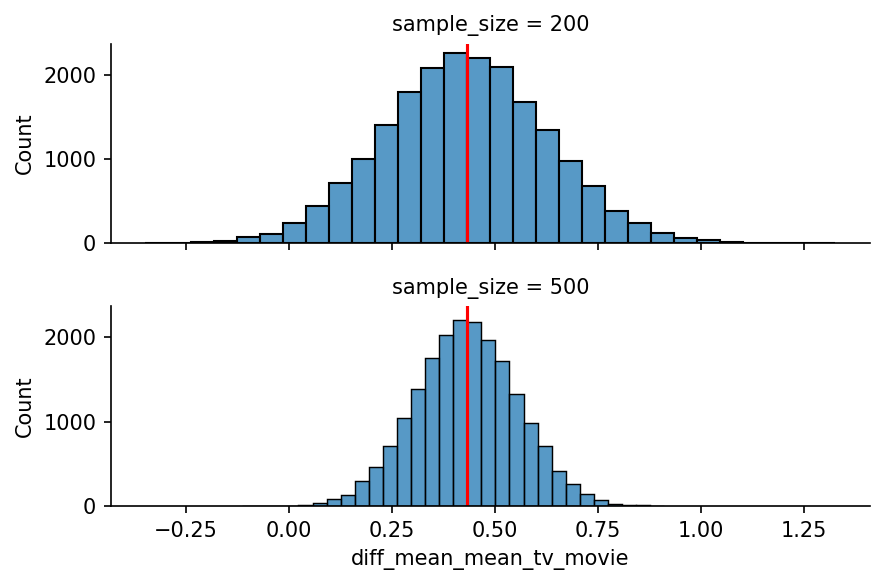

In [30]:
g = sns.FacetGrid(sampling_dist_diffs, row="sample_size", height=2, aspect=3)
g.map(sns.histplot, "diff_mean_mean_tv_movie", bins=30);
g.map(plt.axvline, x=tv_movie_diff, ymin=0, ymax=1, color="red");

In [ ]:
sampling_dist_diffs \
    .groupby("sample_size") \
    .diff_mean_mean_tv_movie \
    .apply(lambda x: np.quantile(x, [0.025, 0.975]))